In [217]:
#| include: false

%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
import torch
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Link to logistic regression implementation: [logistic.py](https://github.com/vikramv17/vikramv17.github.io/blob/main/posts/implementing-logistic-regression/logistic.py)

# Abstract
This blog post attempts to implement a simple logistic regression algorithm for binary classification. The logistic regression algorithm is a supervised learning algorithm that is used for binary classification problems. It is a linear model that uses the logistic function to model the probability of a binary outcome. The logistic function is an S-shaped curve that maps any real-valued number into the range of 0 to 1. The logistic regression algorithm uses gradient descent to optimize the weights of the model. After implementing the algorithm, we will test it on a few datasets and visualize the results. 

# Implement Logistic Regression
## Understanding perceptron.grad()
To implement the logistic regression algorithm we will use the basic Linear Model to score and predict the data. From there, the LogisticRegression.loss() function computes the scores and uses the sigmoid function to transform the scores into probabilities. The loss function is then computed using the logistic loss function for empirical risk minimization. LogisticRegression.grad() computes the gradient of the loss function with respect to the weights. The gradient is then used to update the weights using gradient descent as done in GradientDescentOptimizer.step(). The learning rate (alpha) is a hyperparameter that controls the step size of the weight updates and beta controls the momentum.

# Experiments
To test our logistic regression we will run some experiments and create visualizations. In order to do this we will need to make datasets to test on. We will use the classification_data function to quickly make random datasets with the desired number of dimensions. We also define a couple of graphing functions that will help us to plot the perceptron data along with the calculated thresholds.

In [237]:
plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(1234567)

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

def plot_logistic_regression_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

## Vanilla Gradient Descent
To first check that our logistic regression implementation is working we will run it on a simple dataset with two dimensions without using momentum. A beta value of 0 should have the same effect as gradient descent without momentum, so we will test that by setting beta to 0. We will iterate 1000 times to see how the loss changes over time and plot the final decision boundary. If the loss decreases monotonically, then we can be sure that our implementation is correct.

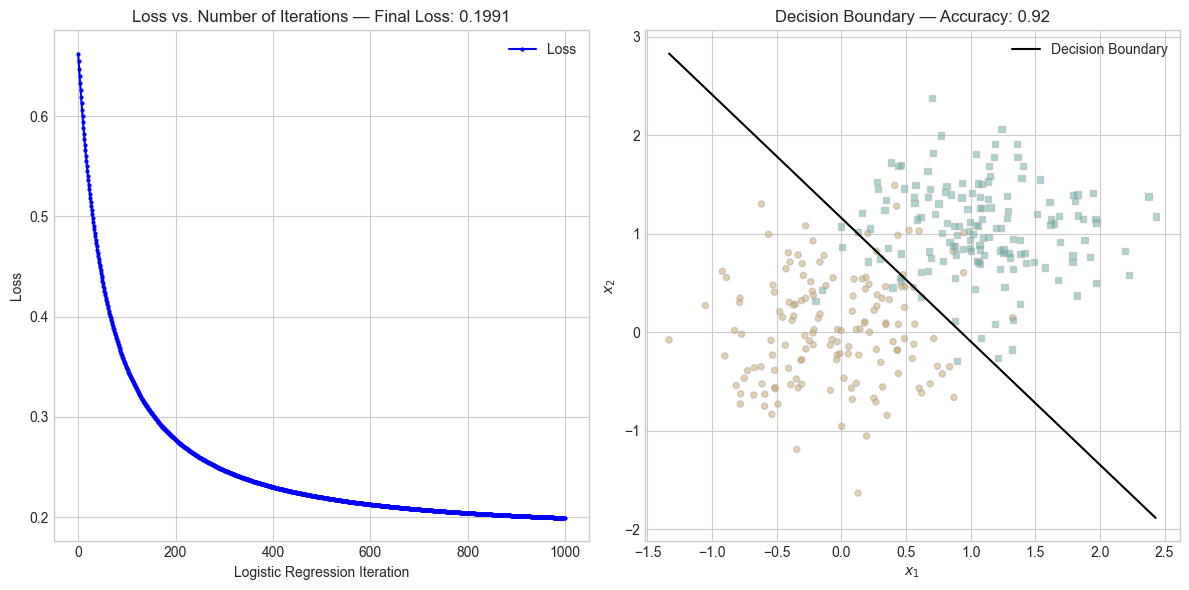

In [298]:
X, y = classification_data(noise = 0.5)

LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss = 1.0

loss_vec = []

for _ in range(1000):
    loss = LR.loss(X, y)
    loss_vec.append(loss) 
    opt.step(X, y, alpha = 0.1, beta = 0)

scores = LR.score(X)
probs = LR.sigmoid(scores)
predictions = (probs >= 0.5).float()
accuracy = (predictions == y).float().mean().item()
final_loss = LR.loss(X, y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(loss_vec, marker='o', color='blue', label='Loss', markersize=2)
axes[0].set_xlabel('Logistic Regression Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Loss vs. Number of Iterations — Final Loss: {final_loss:.4f}')
axes[0].grid(True)
axes[0].legend()

plot_logistic_regression_data(X, y, axes[1])
draw_line(LR.w, X[:, 0].min(), X[:, 0].max(), axes[1], color="black", label="Decision Boundary")
axes[1].set_title(f'Decision Boundary — Accuracy: {accuracy:.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()


As we can see in the above plot, the loss decreases monotonically indicating that our implementation is correct. We also observe that we were able to learn a decision boundary with an accuracy of 93% which is pretty good.

## Benefits of Momentum
Now that we know that our implementation works, we will play around with momentum to see the benefits that its inclusion provides. To do this, we will set the beta value to 0.9 and run the same experiment as before on the same data.

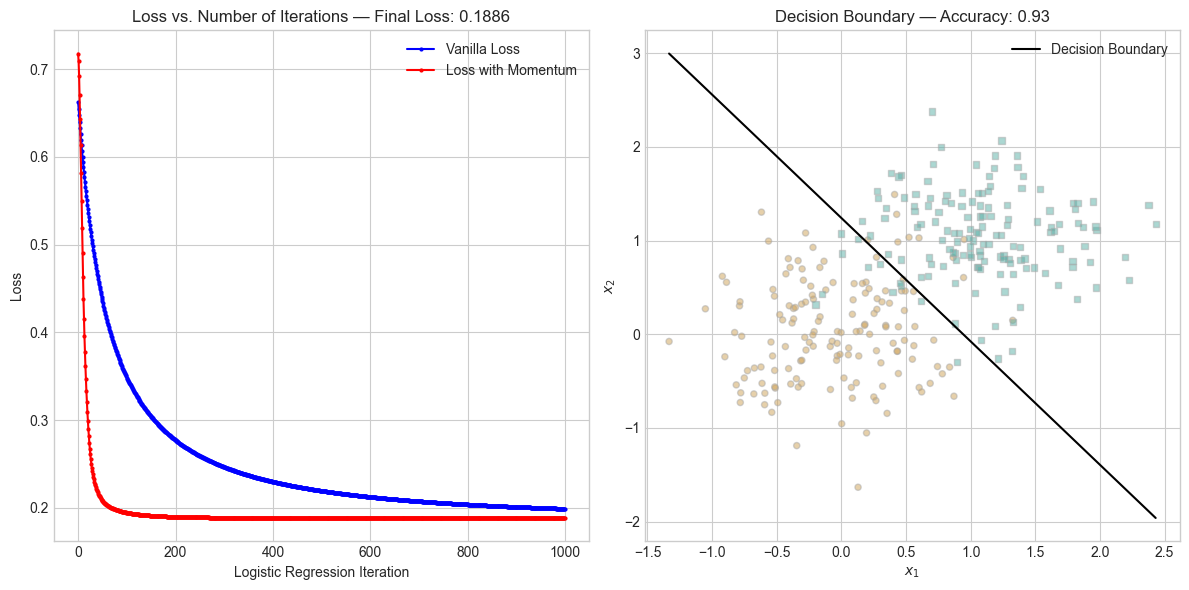

In [299]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss = 1.0

loss_vec_with_momentum = []

for _ in range(1000):
    loss = LR.loss(X, y)
    loss_vec_with_momentum.append(loss) 
    opt.step(X, y, alpha = 0.1, beta = 0.9)

scores = LR.score(X)
probs = LR.sigmoid(scores)
predictions = (probs >= 0.5).float()
accuracy = (predictions == y).float().mean().item()
final_loss = LR.loss(X, y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(loss_vec, marker='o', color='blue', label='Vanilla Loss', markersize=2)
axes[0].plot(loss_vec_with_momentum, marker='o', color='red', label='Loss with Momentum', markersize=2)
axes[0].set_xlabel('Logistic Regression Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Loss vs. Number of Iterations — Final Loss: {final_loss:.4f}')
axes[0].grid(True)
axes[0].legend()

plot_logistic_regression_data(X, y, axes[1])
draw_line(LR.w, X[:, 0].min(), X[:, 0].max(), axes[1], color="black", label="Decision Boundary")
axes[1].set_title(f'Decision Boundary — Accuracy: {accuracy:.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

As we can see, not only did the momentum allow the loss to decrease faster, but it also allowed the final loss to be lower. We can see that the red line (Loss with Momentum) decreases faster and further than the blue line which is the previously calculated vanilla gradient descent. This did not impact our accuracy, but it did show us that momentum can help us to converge faster which is helpful to conserve compute resources.

## Overfitting
The next experiment involves overfitting. We want to see if we can run into pitfalls by overfitting data. To do this we will generate data with 100 dimensions and 50 points. This will create a dataset that is very sparse and will be easy to overfit. We will generate two sets of data with these parameters, training on one and testing on the other to test for overfitting. We will run the experiment until teh training accuracy is 100% and then check the test accuracy. If the test accuracy is significantly lower than the training accuracy, then we can conclude that we have overfit the data.

In [206]:
X_train, y_train = classification_data(n_points=50, noise=0.5, p_dims=100)
X_test, y_test = classification_data(n_points=50, noise=0.5, p_dims=100)

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss_vec = []
for _ in range(1000):
    loss = LR.loss(X_train, y_train)
    loss_vec.append(loss.item())
    opt.step(X_train, y_train, alpha=0.1, beta=0.9)

scores_train = LR.score(X_train)
probs_train = LR.sigmoid(scores_train)
predictions_train = (probs_train >= 0.5).float()
accuracy_train = (predictions_train == y_train).float().mean().item()

scores_test = LR.score(X_test)
probs_test = LR.sigmoid(scores_test)
predictions_test = (probs_test >= 0.5).float()
accuracy_test = (predictions_test == y_test).float().mean().item()

print(f"Training Accuracy: {accuracy_train:.2f}")
print(f"Test Accuracy: {accuracy_test:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.80


As we can see, while we managed to get 100% test accuracy, we only achieved 80% test accuracy, and this is a clear indication that we have overfit the data. This is a common problem with machine learning algorithms and can be avoided by using regularization techniques such as L1 or L2 regularization.

## Performance ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Empirical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Data

Our final test will be on real world data to see how our implementation performs. To this point we have only tested on synthetic data, so we want to see how the algorithm fares with real world data. We will use weather data from Europe collected by European Climate Assessment. While there is several cities in the dataset, we will be looking at Heathrow and trying to predict sunshine. This is significant because one of the biggest airports in the world is in Heathrow and England has a lot of rain so knowing whether it is sunny is important for air travel.

In [296]:
df = pd.read_csv("data/weather.csv")

# limit to just Medu, Fedu, and G3
df = df[["HEATHROW_precipitation", "HEATHROW_sunshine", "HEATHROW_cloud_cover"]]

df_train, df_test = train_test_split(df, test_size=0.6, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.5, random_state=42)
X_train = df_train[["HEATHROW_precipitation", "HEATHROW_cloud_cover"]].values
y_train = df_train["HEATHROW_sunshine"].values
X_val = df_val[["HEATHROW_precipitation", "HEATHROW_cloud_cover"]].values
y_val = df_val["HEATHROW_sunshine"].values
X_test = df_test[["HEATHROW_precipitation", "HEATHROW_cloud_cover"]].values
y_test = df_test["HEATHROW_sunshine"].values
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_train = torch.cat([X_train, torch.ones((X_train.size(0), 1))], dim=1)
X_val = torch.cat([X_val, torch.ones((X_val.size(0), 1))], dim=1)
X_test = torch.cat([X_test, torch.ones((X_test.size(0), 1))], dim=1)
y_train = (y_train > 1).float()
y_val = (y_val > 1).float()
y_test = (y_test > 1).float()
print(f"Test Set Mean: {y_test.mean():.2f}")

Test Set Mean: 0.71


The first step is to pull in the data and clean it up. We will be predicting sunshine using precipitation and cloud cover as features. We will use train, test, split to split the data into training (60%) validation (20%) and test (20%) sets. We define sunshine as a sun value of greater than 1. This is necessary because the data is not binary and we need to convert it into a binary classification problem. We also output the mean of the label to see the baseline that we hope for the model to beat. We see that the mean of the test set is 71 meaning that 71% of the time it is sunny, so if our model is able to predict with an accuracy higher than 71% it can be said to be at least somewhat successful. We will then run the logistic regression algorithm on the data and see how it performs. We will also plot the loss over time on the training and validation sets with and without momentum to see how it performs before testing the trained model on the test set.

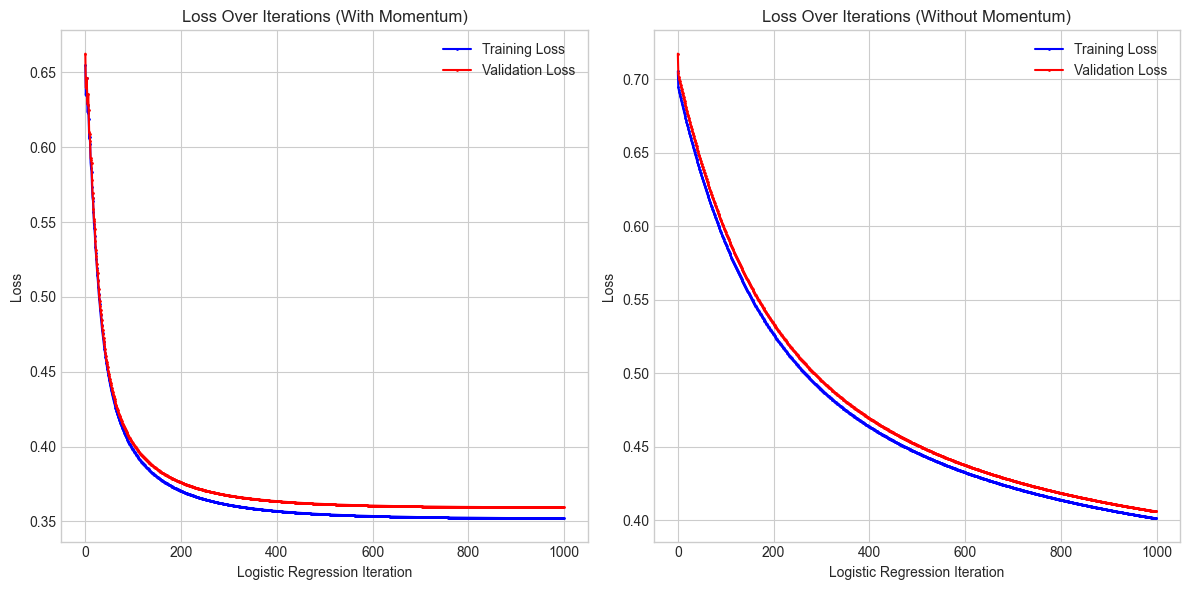

Test Accuracy (With Momentum): 0.84
Final Loss (With Momentum): 0.3487


In [293]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)
LR2 = LogisticRegression()
opt2 = GradientDescentOptimizer(LR2)

loss_vec_momentum = []
loss_vec_momentum_val = []
loss_vec_no_momentum = []
loss_vec_no_momentum_val = []
loss = 1.0
loss2 = 1.0

for _ in range(1000):
    loss = LR.loss(X_train, y_train)
    loss_val = LR.loss(X_val, y_val)
    loss_vec_momentum.append(loss.item())
    loss_vec_momentum_val.append(loss_val.item())
    opt.step(X_train, y_train, alpha=0.1, beta=0.9)

    loss2 = LR2.loss(X_train, y_train)
    loss_val2 = LR2.loss(X_val, y_val)
    loss_vec_no_momentum.append(loss2.item())
    loss_vec_no_momentum_val.append(loss_val2.item())
    opt2.step(X_train, y_train, alpha=0.1, beta=0)

scores_val = LR2.score(X_val)
probs_val = LR2.sigmoid(scores_val)
predictions_val = (probs_val >= 0.5).float()
accuracy_val = (predictions_val == y_val).float().mean().item()
final_loss_val = LR2.loss(X_val, y_val)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(loss_vec_momentum, marker='o', color='blue', label='Training Loss', markersize=1)
axes[0].plot(loss_vec_momentum_val, marker='o', color='red', label='Validation Loss', markersize=1)
axes[0].set_xlabel('Logistic Regression Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Iterations (With Momentum)')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(loss_vec_no_momentum, marker='o', color='blue', label='Training Loss', markersize=1)
axes[1].plot(loss_vec_no_momentum_val, marker='o', color='red', label='Validation Loss', markersize=1)
axes[1].set_xlabel('Logistic Regression Iteration')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Over Iterations (Without Momentum)')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

scores_test = LR.score(X_test)
probs_test = LR.sigmoid(scores_test)
predictions_test = (probs_test >= 0.5).float()
accuracy_test = (predictions_test == y_test).float().mean().item()
final_loss_test = LR.loss(X_test, y_test)
print(f"Test Accuracy (With Momentum): {accuracy_test:.2f}")
print(f"Final Loss (With Momentum): {final_loss_test:.4f}")

As we see in the plots, the loss converges much faster with momentum as we observed in the second experiment. We also observe a test accuracy of 84% which exceeds the baseline of 71% indicating that our implementation is working well even when tested on real world data. 

## Discussion
Overall, by implementing the logistic regression with momentum, we learned about the advantages of using momentum in gradient descent. We also learned about the pitfalls of overfitting and how to avoid them. Finally, we were able to test our implementation on real world data and see that it performed well. This is a good indication that our implementation is correct and can be used for other datasets as well.